# Practical 1 - Motion Estimation

## Setup

### Import necessay libraries

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

### Import images

#### Utility functions

In [10]:
def load_image(path: str) -> np.ndarray:
    """
    Load image from path and convert it to RGB
    
    :param path: path to image
    :return: image in RGB
    """
    img = cv2.imread(path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def display_image(img: np.ndarray, title: str = "") -> None:
    """
    Display image with matplotlib

    :param img: image to display
    :param title: title of the image
    """
    plt.imshow(img, cmap="gray")
    plt.title(title)
    plt.show()

#### Load images and display chosen samples

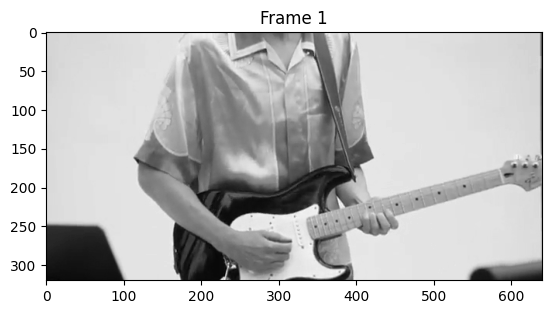

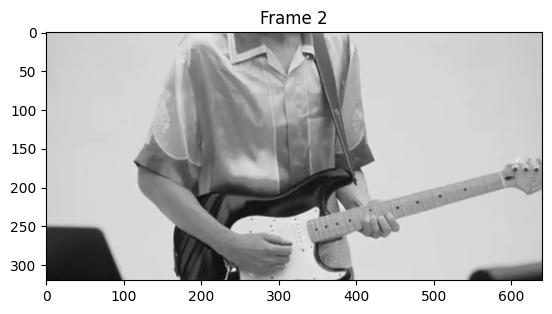

In [11]:
# Load two consecutive frames
frame1: np.ndarray = load_image("./images/Part1/LF000.jpg")
frame2: np.ndarray = load_image("./images/Part1/LF001.jpg")

# Display chosen frames
display_image(frame1, "Frame 1")
display_image(frame2, "Frame 2")

## A - Pixel wise motion estimation

In [12]:
def pixel_wise_motion_estimation(frame1: np.ndarray, frame2: np.ndarray, neighborhood: int = 5) -> tuple[np.ndarray]:
    """
    Compute the motion estimation between two frames using pixel-wise motion estimation

    :param frame1: first frame
    :param frame2: second frame
    :return: motion vectors
    """
    assert frame1.shape == frame2.shape, "Frames must have the same shape"

    frame_shape = frame1.shape
    frame1 = frame1 / 255
    frame2 = frame2 / 255

    v_x = np.zeros(frame_shape, dtype='int')
    v_y = np.zeros(frame_shape, dtype='int')

    for i in range(frame_shape[0]):
        for j in range(frame_shape[1]):
            min_x = max(0, i - neighborhood)
            max_x = min(frame_shape[0], i + neighborhood)

            min_y = max(0, j - neighborhood)
            max_y = min(frame_shape[1], j + neighborhood)

            E = np.inf
            new_x = 0
            new_y = 0

            for k in range(min_x, max_x):
                should_break = False
                for l in range(min_y, max_y):
                    if frame1[k, l] == frame2[i, j] and (k == i and l == j):
                        new_x = 0
                        new_y = 0
                        should_break = True
                        break
                    
                    E_new = (frame2[k, l] - frame1[i, j]) ** 2
                    diff_x = k - i
                    diff_y = l - j
                    
                    if E_new < E:
                        E = E_new
                        new_x = diff_x
                        new_y = diff_y
                    elif E_new == E and (diff_x < new_x or diff_y < new_y):
                        new_x = diff_x
                        new_y = diff_y

                if should_break:
                    break
            
            v_x[i, j] = new_x
            v_y[i, j] = new_y
    
    return v_x, v_y

In [13]:
# Compute motion estimation
motion_x, motion_y = pixel_wise_motion_estimation(frame1, frame2, neighborhood=3)

### Visualize motion vectors

(64,) (32,) (320, 640) (320, 640)


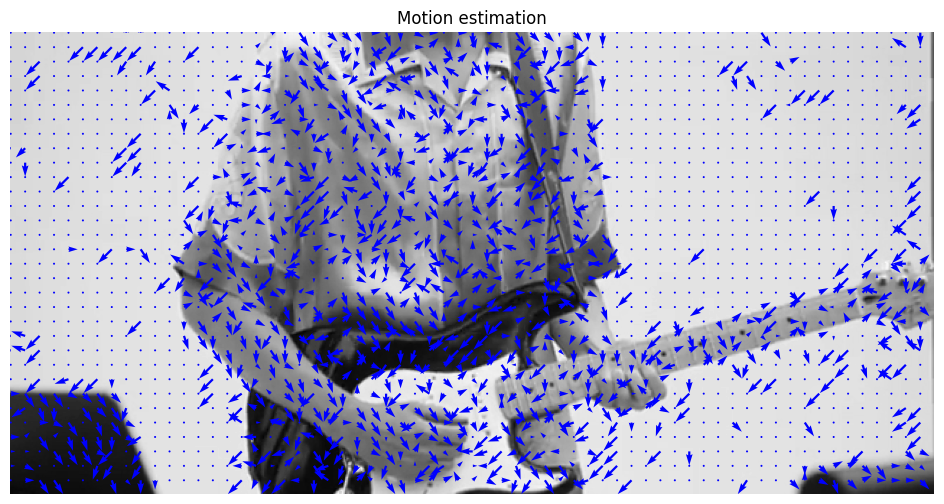

In [14]:
def display_motion_estimation(u: np.ndarray, v: np.ndarray, frame: np.ndarray, step: int = 5) -> None:
    """
    Display the motion estimation between two frames

    :param u: first frame
    :param v: second frame
    """
    # Pixel coordinates
    x_coords = np.arange(0, frame1.shape[1], step)
    y_coords = np.arange(0, frame1.shape[0], step)

    print(x_coords.shape, y_coords.shape, u.shape, v.shape)

    u = u[::step, ::step]
    v = v[::step, ::step]

    _, ax = plt.subplots(1, 1, figsize=(15, 6))
    ax.imshow(frame, cmap='gray')
    ax.set_axis_off()
    ax.set_title('Motion estimation')
    
    ax.quiver(x_coords, y_coords, u, v, scale=200, color='blue')
    plt.show()

# Display motion estimation
display_motion_estimation(motion_x, motion_y, frame1, step=10)

## B - Block Matching Algorithm (BMA)

In [15]:
def BMA(frame1: np.ndarray , frame2: np.ndarray, block_size: int = 16, window_size: int = 7) -> tuple[np.ndarray]:
    """
    Compute the motion estimation between two frames using the block matching algorithm

    :param frame1: first frame
    :param frame2: second frame
    :return: motion vectors
    """
    assert frame1.shape == frame2.shape, "Frames must have the same shape"

    frame_shape = frame1.shape
    frame1 = frame1 / 255
    frame2 = frame2 / 255

    r_i = range(0, frame_shape[0], block_size)
    r_j = range(0, frame_shape[1], block_size)
    l_r_i = len(r_i)
    l_r_j = len(r_j)

    v_x = np.zeros((l_r_i, l_r_j), dtype='int')
    v_y = np.zeros((l_r_i, l_r_j), dtype='int')

    for i in r_i:
        for j in r_j:
            current_block = frame1[i:i+block_size, j:j+block_size]

            E = np.inf
            new_x = 0
            new_y = 0

            for k in range(i - window_size, i + window_size):
                should_break = False
                for l in range(j - window_size, j + window_size):
                    if k == i and l == j and frame1[i, j] == frame2[k, l]:
                        new_x = 0
                        new_y = 0
                        should_break = True

                    new_block = frame2[k:k+block_size, l:l+block_size]
                    if new_block.shape != current_block.shape:
                        continue

                    E_new = np.sum(np.abs((new_block - current_block)) ** 2)

                    diff_x = k - i
                    diff_y = l - j

                    if E_new < E:
                        E = E_new
                        new_x = diff_x
                        new_y = diff_y
                    
                    elif E_new == E and (diff_x < new_x or diff_y < new_y):
                        new_x = diff_x
                        new_y = diff_y
                
                if should_break:
                    break

            v_x[i // block_size, j // block_size] = new_x
            v_y[i // block_size, j // block_size] = new_y

    return v_x, v_y

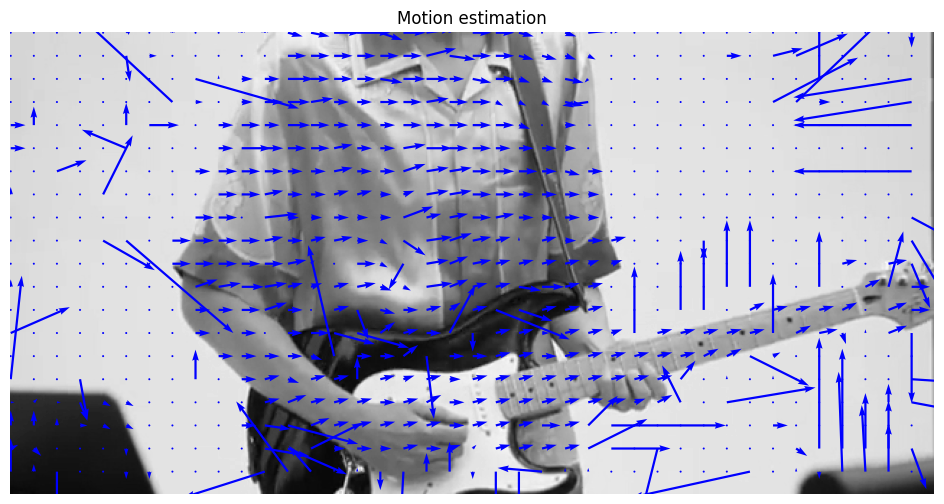

In [16]:
def BMA_display(frame1: np.ndarray, frame2: np.ndarray, block_size: int = 16, window_size: int = 10) -> None:
    v_x , v_y = BMA(frame1, frame2, block_size=block_size, window_size=window_size)

    x_coords = np.arange(0, frame1.shape[1], block_size)
    y_coords = np.arange(0, frame1.shape[0], block_size)

    _, ax = plt.subplots(1, 1, figsize=(15, 6))
    ax.imshow(frame1, cmap='gray')
    ax.set_axis_off()
    ax.set_title('Motion estimation')

    ax.quiver(x_coords, y_coords, v_x, v_y, scale=250, color='blue')
    plt.show()

BMA_display(frame1, frame2, block_size=16, window_size=32)